# Grid World

<img src="gridworld.png" alt="Drawing" style="width: 400px;"/>

### Set Rewards


$A = 2$ and $A^{'} = 22$ are special states. Any action in $A$ takes to $A^{'}$ with reward of 10

$B = 4$ and $B^{'} = 14$ are special states. Any action in $B$ takes to $B^{'}$ with reward of 5

Any action in boundary state which transitions to state outside grid results in reward of -1 with no change in state

All other actions in states give reward of 0

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
np.random.seed(100)
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['figure.dpi'] = 100

In [2]:
R_s_a = {}
actions = ['l', 'u', 'r', 'd']
action_map = {1:'l', 2:'u', 3:'r', 4:'d'}

#initialize rewards
for state in range(1, 26):
    for action in actions:
        R_s_a[(state, action)] = 0

# reward for boundary states
for state in [1, 6, 11, 16, 21]:
    R_s_a[(state, 'l')] = -1

for state in [1, 2, 3, 4, 5]:
    R_s_a[(state, 'u')] = -1

for state in [5, 10, 15, 20, 25]:
    R_s_a[(state, 'r')] = -1

for state in [21, 22, 23, 24, 25]:
    R_s_a[(state, 'd')] = -1

# reward for special states
for action in actions:
    R_s_a[(2, action)] = 10
    R_s_a[(4, action)] = 5

def get_reward(state, action):
    action = action_map[action]
    return R_s_a[(state, action)]

### Policy

In [3]:
def policy(state, theta, X):
    action = 1
    p = np.exp(np.matmul(X[state-1], theta).reshape(-1)) / \
    np.sum(np.exp(np.matmul(X[state-1], theta).reshape(-1)), keepdims=False)
    p_cumulative = np.cumsum(p)
    threshold = np.random.uniform(0, 1)
    for idx in range(p.shape[0]-2, -1, -1):
        if threshold > p_cumulative[idx]:
            action = idx+2
            break
    return action, p



### State Transition

In [4]:
def get_next_state(current_state, action):
    current_state = current_state - 1
    action = action_map[action]
    next_state = current_state
    grid_row = current_state // 5
    grid_column = current_state % 5
    if action == 'u':
        est_next_state = current_state - 5
        est_grid_row = est_next_state // 5
        if est_grid_row >= 0:
            next_state = est_next_state
    elif action == 'd':
        est_next_state = current_state + 5
        est_grid_row = est_next_state // 5
        if est_grid_row <= 4:
            next_state = est_next_state
    elif action == 'l':
        est_next_state = current_state - 1
        est_grid_row = est_next_state // 5
        if est_grid_row == grid_row:
            next_state = est_next_state
    elif action == 'r':
        est_next_state = current_state + 1
        est_grid_row = est_next_state // 5
        if est_grid_row == grid_row:
            next_state = est_next_state
    if current_state == 1:
        next_state = 21
    if current_state == 3:
        next_state = 13
    next_state = next_state + 1
    return next_state

### A step in the grid

In [5]:
def step(state, action):
    return get_next_state(state, action), get_reward(state, action)

# Algorithm 1

$\hat{J}_{t+1} = (1 - \zeta_{t})\hat{J}_{t} + \zeta_{t}r_{t+1}$ <br>
$\delta_{t} = r_{t+1} - \hat{J}_{t+1} + v^{T}_{t}f_{s_{t+1}} - v^{T}_{t}f_{s_{t}}$<br>
$v_{t+1} = v_{t} + \alpha_{t}\delta_{t}f_{s_{t}}$<br>
$\theta_{t+1} = \theta_{t} + \beta_{t}\delta_{t}\psi_{s_{t},a_{t}}$<br>
<br>
Where,<br>
$\zeta_{t} = c\alpha_{t}$<br>
$\frac{\beta_{t}}{\alpha_{t}} \to 0$, as $t \to \infty$<br>
$\sum \limits _{t} \alpha_{t} = \sum \limits _{t} \beta_{t} = \infty$<br>
$\sum \limits _{t} \alpha^{2}_{t} < \infty, \sum \limits _{t} \beta^{2}_{t} < \infty$

In [6]:
def state_feature(state, case=1):
    feature = None
    if case == 1:
        feature = np.array([state / 25])
    elif case == 2:
        feature = np.array([1, state/25, (state/25)**2])
    return feature


In [7]:
def state_action_feature(state, action, case=1):
    feature = None
    if case == 1:
        feature = np.array([1, state/25, action/4])
    else:
        feature = np.array([1, state/25, (state/25)**2, action/4, (action/4)**2, state*action/100])
    return feature

In [8]:
def psi(state, action, theta, X_state_action, case=1):
    psi_ = X_state_action[state-1][action-1]
    _, p = policy(state, theta, X_state_action)
#     print(p, p.shape)
#     print(X_state_action[state-1], X_state_action[state-1].shape)
    psi_ = psi_ - np.dot(p, X_state_action[state-1])
    return psi_ #, p, X_state_action[state-1]
        

In [9]:
def algorithm1(seed=123, iterations=10000, c=1, case=1, verbose=False):
    np.random.seed(seed)
    state = 1 + np.random.choice(25)
#     state=13
#     v = np.zeros((1, 1)) if case == 1 else np.zeros((3, 1))
#     theta = np.zeros((3, 1)) if case == 1 else np.zeros((6, 1))
    v = np.zeros(1) if case == 1 else np.zeros(3)
    theta = np.zeros(3) if case == 1 else np.zeros(6)
    J = [0]
    X_state_action = np.array([state_action_feature(state, action, case) for state in range(1, 26) for action in range(1, 5) ]).reshape(25, 4, -1)
    X_state = np.array([state_feature(state, case) for state in range(1, 26)]).reshape(25, -1)
    for iter_ in range(iterations):
        alpha = 1 / (1 + iter_**(2/3))
        beta = 1 / (1 + iter_)
        zeta = c*alpha
        action, _ = policy(state, theta, X_state_action)
        next_state, reward = step(state, action)
        J_ = (1 - zeta)*J[-1] + zeta*reward
        delta = reward - J_ + np.matmul(state_feature(next_state, case), v) - np.matmul(state_feature(state, case), v)
        v = v + alpha*delta*state_feature(state, case)
        theta = theta + beta*delta*psi(state, action, theta, X_state_action, case)
        J.append(J_)
        if verbose:
            if (iter_+1) % 1000 == 0: print("{} iteration run...".format(iter_))
    return J, v, theta


# Algorithm 2

In [10]:
def algorithm2(seed=123, iterations=10000, c=1, case=1, verbose=False):
    np.random.seed(seed)
    state = 1 + np.random.choice(25)
    v = np.zeros(1) if case == 1 else np.zeros(3)
    theta = np.zeros(3) if case == 1 else np.zeros(6)
    G_inverse = 1.5*np.identity(3) if case == 1 else 1.5*np.identity(6)
    J = [0]
    X_state_action = np.array([state_action_feature(state, action, case) for state in range(1, 26) for action in range(1, 5) ]).reshape(25, 4, -1)
    X_state = np.array([state_feature(state, case) for state in range(1, 26)]).reshape(25, -1)
    for iter_ in range(iterations):
        alpha = 1 / (1 + iter_**(2/3))
        beta = 1 / (1 + iter_)
        zeta = c*alpha
        action, _ = policy(state, theta, X_state_action)
        next_state, reward = step(state, action)
        J_ = (1 - zeta)*J[-1] + zeta*reward
        delta = reward - J_ + np.matmul(state_feature(next_state, case), v) - np.matmul(state_feature(state, case), v)
        v = v + alpha*delta*state_feature(state, case)
        theta = theta + beta*delta*np.matmul(G_inverse, psi(state, action, theta, X_state_action, case))
        G_inverse = (1/(1 - 0.001*alpha))*(G_inverse - (0.001*alpha*np.matmul(np.matmul(G_inverse, psi(state, action, theta, X_state_action, case).reshape(-1, 1)), np.matmul(G_inverse, psi(state, action, theta, X_state_action, case).reshape(-1, 1)).T))/(1 - 0.001*alpha + 0.001*alpha*np.matmul(np.matmul(psi(state, action, theta, X_state_action, case).reshape(1, -1), G_inverse), psi(state, action, theta, X_state_action, case).reshape(-1, 1))[0][0]))
        J.append(J_)
        if verbose:
            if (iter_+1) % 1000 == 0: print("{} iteration run...".format(iter_))
    return J, v, theta


In [11]:
NUM_SIMULATIONS = 10
ITERATIONS = 10000
seeds = np.random.choice(1000000, NUM_SIMULATIONS)
print(seeds)

[824840  56088 210755 778087 864087  65615 212912 718730 344414 931764]


## Case 1

### Algorithm 1

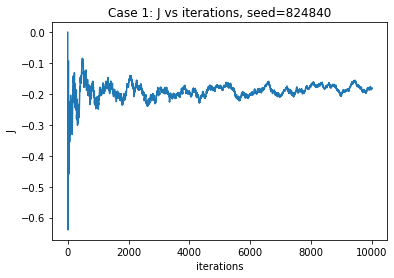

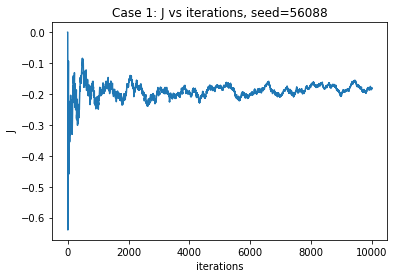

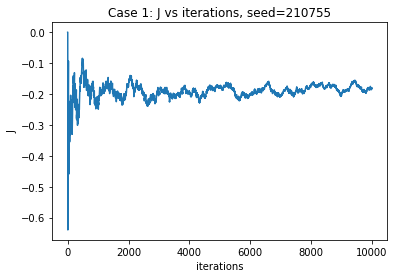

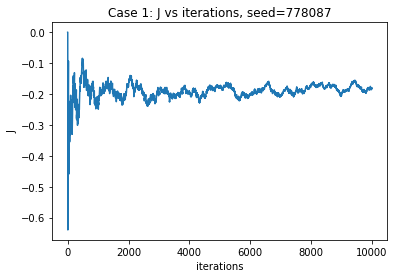

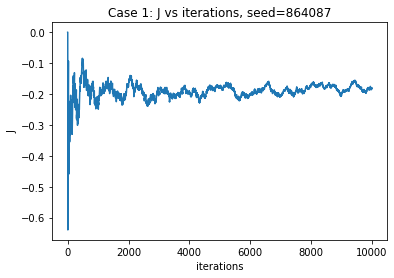

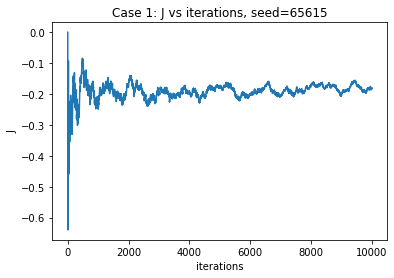

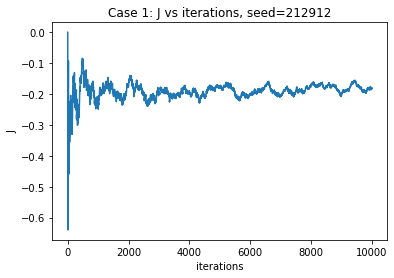

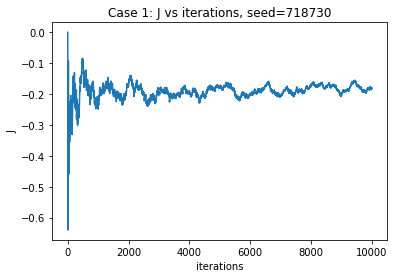

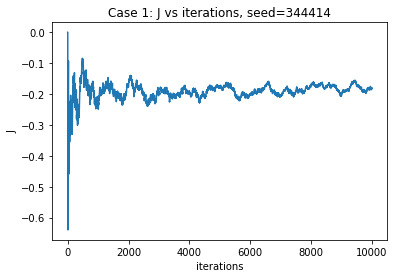

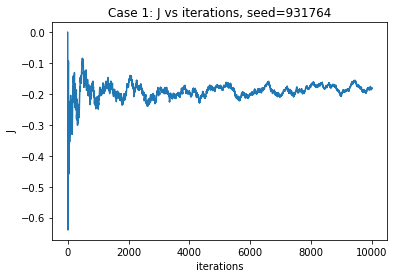

In [12]:
J_simulations = []
case = 1
for i in range(len(seeds)):
    seed = seeds[i]
    J, v, theta = algorithm1(seed=1234, iterations=ITERATIONS, c=1, case=case, verbose=False)
    J_simulations.append(J)
    plt.figure(i)
    plt.plot(J)
    plt.xlabel('iterations')
    plt.ylabel('J')
    plt.title('Case {}: J vs iterations, seed={}'.format(case, seed))

J_simulations_algo1 = np.array(J_simulations)[:, 1:].T
J_algo1 = pd.DataFrame({'Iteration': range(1, J_simulations_algo1.shape[0]+1), 'J_avg': np.mean(J_simulations_algo1, axis=1), 'J_std': np.std(J_simulations_algo1, axis=1)})

In [13]:
J_algo1.head(1000)

,Iteration,J_avg,J_std
0,1,0.000000,0.000000e+00
1,2,0.000000,0.000000e+00
2,3,0.000000,0.000000e+00
3,4,-0.324666,5.551115e-17
4,5,-0.516531,1.110223e-16
5,6,-0.639739,1.110223e-16
6,7,-0.491029,5.551115e-17
7,8,-0.600267,1.110223e-16
8,9,-0.480213,0.000000e+00
9,10,-0.390062,0.000000e+00


### Algorithm 2

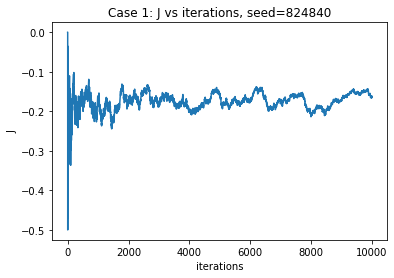

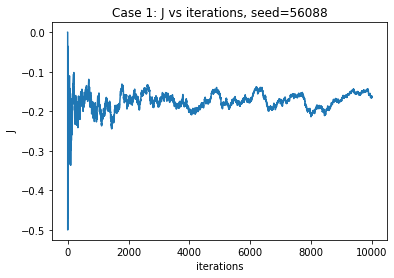

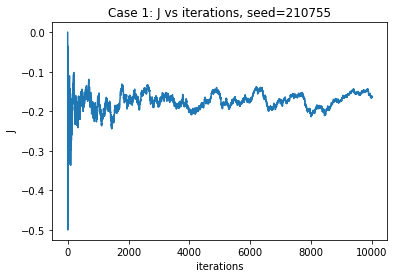

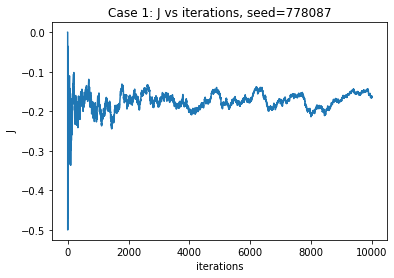

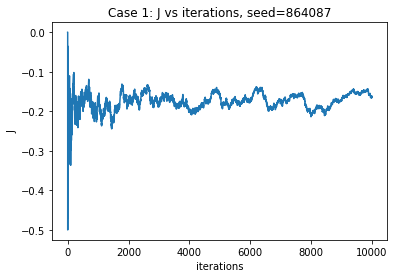

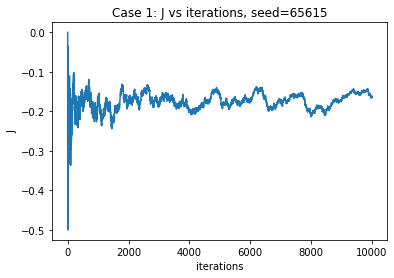

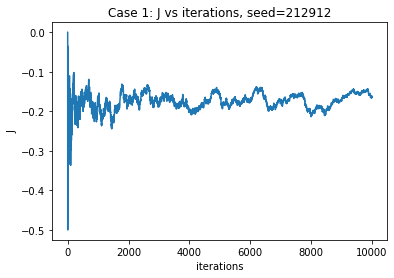

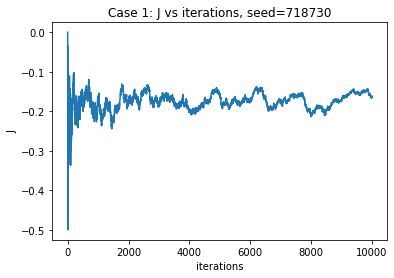

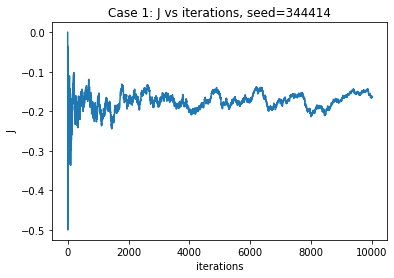

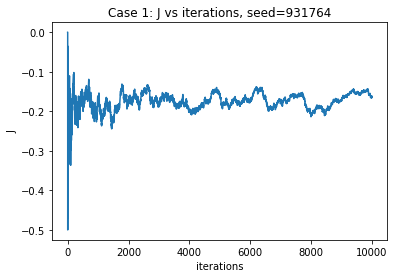

In [14]:
J_simulations = []
case = 1
for i in range(len(seeds)):
    seed = seeds[i]
    J, v, theta = algorithm2(seed=1234, iterations=ITERATIONS, c=1, case=case, verbose=False)
    J_simulations.append(J)
    plt.figure(i)
    plt.plot(J)
    plt.xlabel('iterations')
    plt.ylabel('J')
    plt.title('Case 1: J vs iterations, seed={}'.format(seed))

J_simulations_algo2 = np.array(J_simulations)[:, 1:].T
J_algo2 = pd.DataFrame({'Iteration': range(1, J_simulations_algo2.shape[0]+1), 'J_avg': np.mean(J_simulations_algo2, axis=1), 'J_std': np.std(J_simulations_algo2, axis=1)})

In [15]:
J_algo2.head(1000)

,Iteration,J_avg,J_std
0,1,0.000000,0.000000e+00
1,2,-0.500000,0.000000e+00
2,3,-0.306756,5.551115e-17
3,4,-0.207163,0.000000e+00
4,5,-0.148307,0.000000e+00
5,6,-0.110512,0.000000e+00
6,7,-0.084823,1.387779e-17
7,8,-0.066618,1.387779e-17
8,9,-0.053294,0.000000e+00
9,10,-0.043289,0.000000e+00


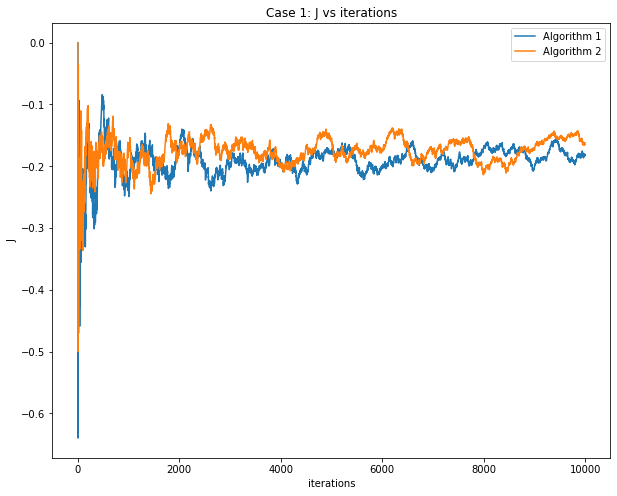

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(J_algo1['J_avg'])
plt.plot(J_algo2['J_avg'])
plt.xlabel('iterations')
plt.ylabel('J')
plt.title('Case 1: J vs iterations')
plt.legend(['Algorithm 1', 'Algorithm 2'])

## Case 2

### Algorithm 1

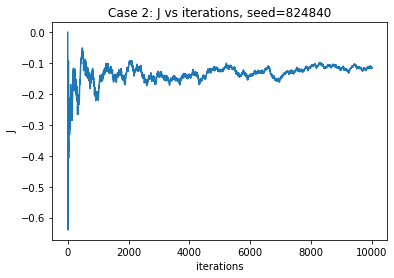

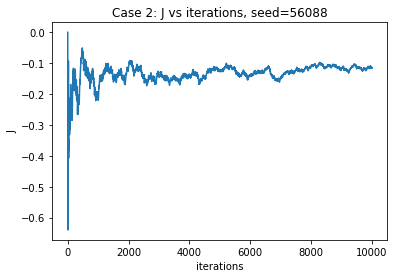

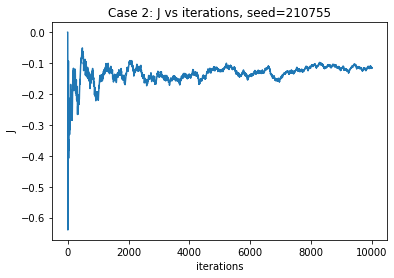

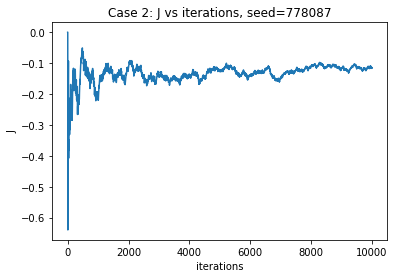

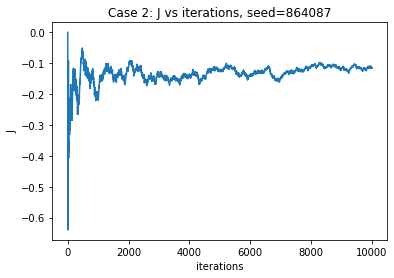

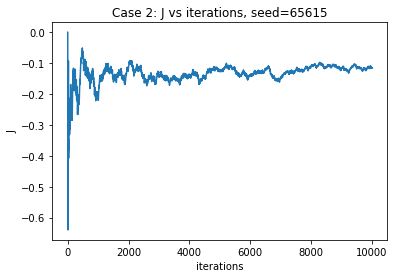

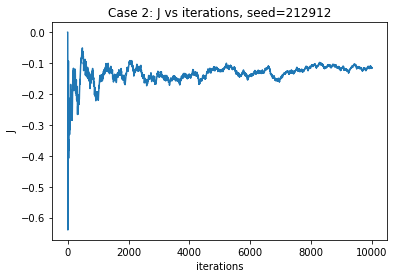

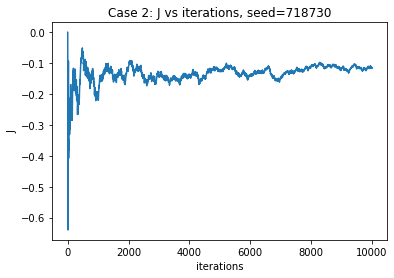

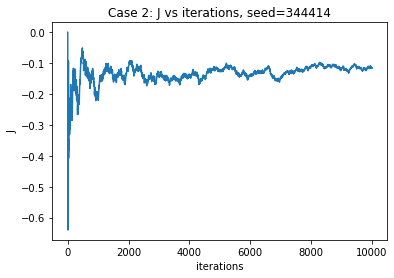

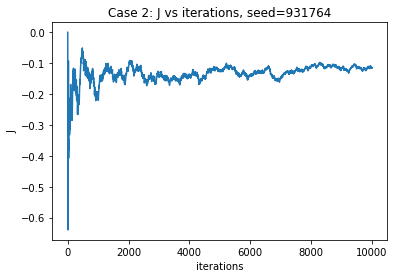

In [17]:
J_simulations = []
case = 2
for i in range(len(seeds)):
    seed = seeds[i]
    J, v, theta = algorithm1(seed=1234, iterations=ITERATIONS, c=1, case=case, verbose=False)
    J_simulations.append(J)
    plt.figure(i)
    plt.plot(J)
    plt.xlabel('iterations')
    plt.ylabel('J')
    plt.title('Case {}: J vs iterations, seed={}'.format(case, seed))

J_simulations_algo1 = np.array(J_simulations)[:, 1:].T
J_algo1 = pd.DataFrame({'Iteration': range(1, J_simulations_algo1.shape[0]+1), 'J_avg': np.mean(J_simulations_algo1, axis=1), 'J_std': np.std(J_simulations_algo1, axis=1)})

In [18]:
J_algo1.head(1000)

,Iteration,J_avg,J_std
0,1,0.000000,0.000000e+00
1,2,0.000000,0.000000e+00
2,3,0.000000,0.000000e+00
3,4,-0.324666,5.551115e-17
4,5,-0.516531,1.110223e-16
5,6,-0.639739,1.110223e-16
6,7,-0.491029,5.551115e-17
7,8,-0.600267,1.110223e-16
8,9,-0.480213,0.000000e+00
9,10,-0.390062,0.000000e+00


### Algorithm 2

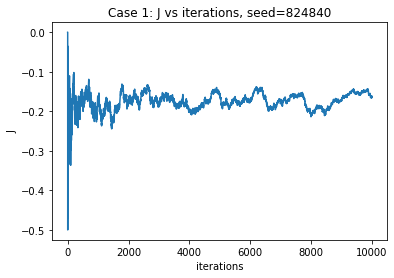

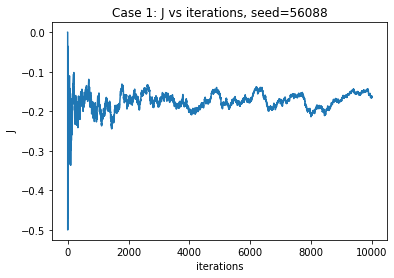

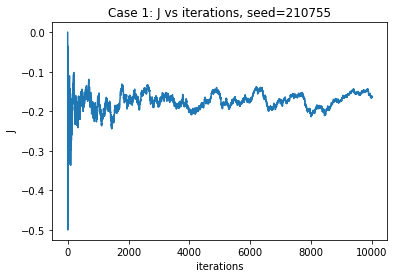

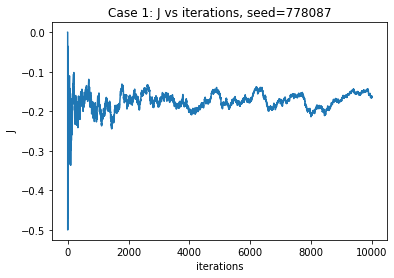

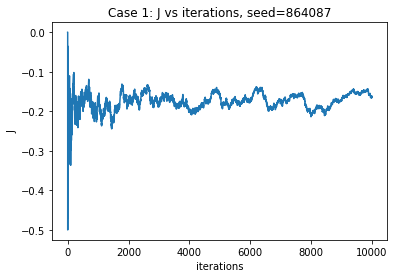

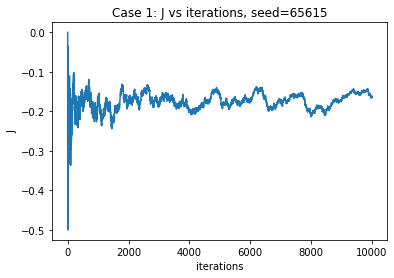

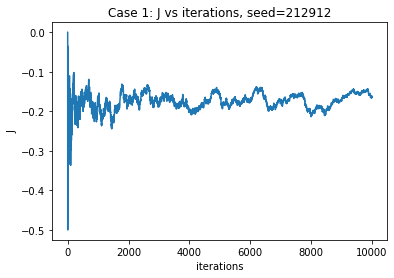

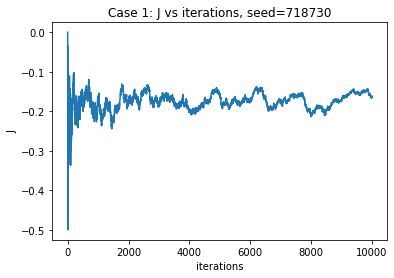

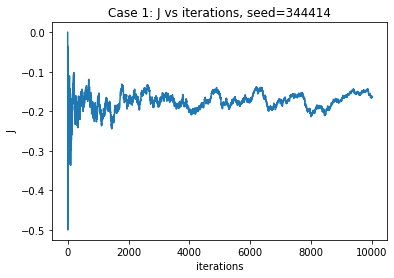

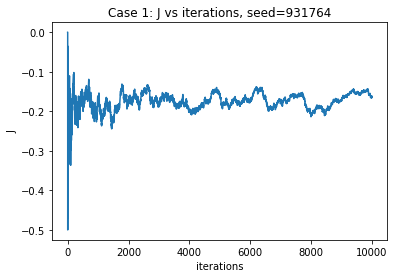

In [19]:
J_simulations = []
case = 1
for i in range(len(seeds)):
    seed = seeds[i]
    J, v, theta = algorithm2(seed=1234, iterations=ITERATIONS, c=1, case=case, verbose=False)
    J_simulations.append(J)
    plt.figure(i)
    plt.plot(J)
    plt.xlabel('iterations')
    plt.ylabel('J')
    plt.title('Case 1: J vs iterations, seed={}'.format(seed))

J_simulations_algo2 = np.array(J_simulations)[:, 1:].T
J_algo2 = pd.DataFrame({'Iteration': range(1, J_simulations_algo2.shape[0]+1), 'J_avg': np.mean(J_simulations_algo2, axis=1), 'J_std': np.std(J_simulations_algo2, axis=1)})

In [20]:
J_algo2.head(1000)

,Iteration,J_avg,J_std
0,1,0.000000,0.000000e+00
1,2,-0.500000,0.000000e+00
2,3,-0.306756,5.551115e-17
3,4,-0.207163,0.000000e+00
4,5,-0.148307,0.000000e+00
5,6,-0.110512,0.000000e+00
6,7,-0.084823,1.387779e-17
7,8,-0.066618,1.387779e-17
8,9,-0.053294,0.000000e+00
9,10,-0.043289,0.000000e+00


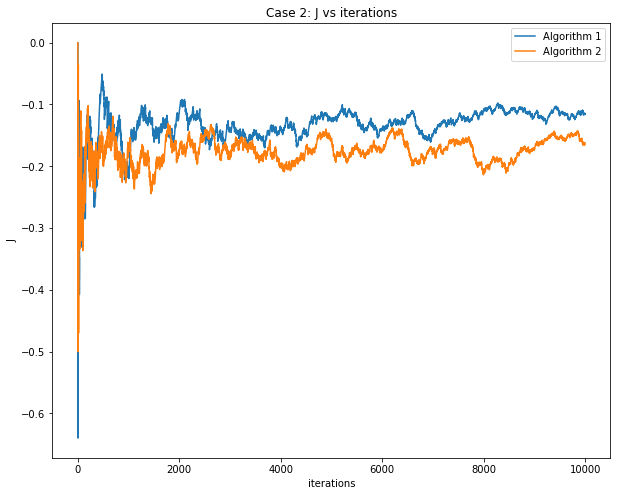

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(J_algo1['J_avg'])
plt.plot(J_algo2['J_avg'])
plt.xlabel('iterations')
plt.ylabel('J')
plt.title('Case 2: J vs iterations')
plt.legend(['Algorithm 1', 'Algorithm 2'])

# Conclusions:

1. In Case 1 Algorithm 1 and Algorithm 2 compete against each other, with Algorithm 2 performing better than Algorithm 1 for majority of time
2. In Case 2 Algorithm 1 is performing better than Algorithm 2
3. In both cases the algorithms converge as number of iterations increase